# 你的第一个神经网络

主要目标： 使用数据训练神经网络模型，预测每天每小时内自行车租客人数

1. 观察数据，特征工程（category转成Indicators、Normalization），数据拆分策略
2. 构建神经网络结构、参数、激活函数、前向传播、反向传播（梯度下降），单元测试，最后训练数据
3. 神经网络调参（hyperparameter）： 迭代次数，学习速率（learning rate），hidden units的数量。
4. 使用测试集评估神经网络模型


In [1]:
%matplotlib inline

# A set of figure formats to enable: ‘png’, ‘retina’, ‘jpeg’, ‘svg’, ‘pdf’.
%config InlineBackend.figure_format = 'retina'

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## 数据预处理

此数据集包含的是从 2011 年 1 月 1 日到 2012 年 12 月 31 日期间每天每小时的骑车人数。骑车用户分成临时用户和注册用户，cnt 列是骑车用户数汇总列。

下图展示的是数据集中前 10 天左右的骑车人数（某些天不一定是 24 个条目，所以不是精确的 10 天）。你可以在这里看到每小时租金。这些数据很复杂！周末的骑行人数少些，工作日上下班期间是骑行高峰期。我们还可以从上方的数据中看到温度、湿度和风速信息，所有这些信息都会影响骑行人数。你需要用你的模型展示所有这些数据。

In [2]:
data_path = 'Bike-Sharing-Dataset/hour.csv'
rides = pd.read_csv(data_path)
print(rides.shape)
rides.head()

(17379, 17)


,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


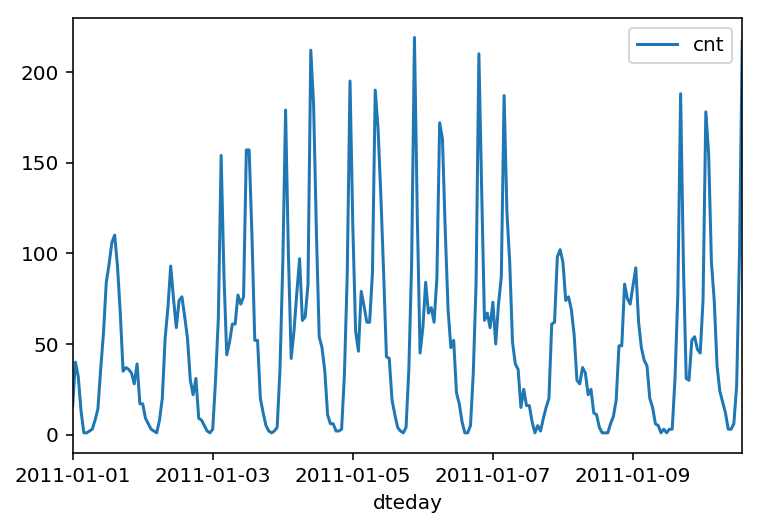

In [3]:
rides[:24*10].plot(x='dteday', y='cnt')

### Category to Indicator

将分类变量，例如 season季节、weathersit天气?、mnth月份、hr小时数、weekday星期几，变成dummies/indicator。用 Pandas 库中的 `get_dummies()` 就可以轻松实现。
（get_dummies: Convert categorical variable into dummy/indicator variables）

> 虽然分类变量是数值，但其实是Label Encoding， 取值范围有限，且值的大小没有意义。 转成dummies 是一个二进制变量，更有利？？

一些变量没有意义：  instant序号， atemp？？， 以及上面这些分类变量。

workingday和dteday为什么删掉？ 感觉有用啊。



In [4]:
dummy_fields = ['season', 'weathersit', 'mnth', 'hr', 'weekday']
for each in dummy_fields:
    dummies = pd.get_dummies(rides[each], prefix=each, drop_first=False)
    rides = pd.concat([rides, dummies], axis=1)

fields_to_drop = ['instant', 'dteday', 'season', 'weathersit', 
                  'weekday', 'atemp', 'mnth', 'workingday', 'hr']
data = rides.drop(fields_to_drop, axis=1)
data.head()

,yr,holiday,temp,hum,windspeed,casual,registered,cnt,season_1,season_2,...,hr_21,hr_22,hr_23,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6
0,0,0,0.24,0.81,0.0,3,13,16,1,0,...,0,0,0,0,0,0,0,0,0,1
1,0,0,0.22,0.80,0.0,8,32,40,1,0,...,0,0,0,0,0,0,0,0,0,1
2,0,0,0.22,0.80,0.0,5,27,32,1,0,...,0,0,0,0,0,0,0,0,0,1
3,0,0,0.24,0.75,0.0,3,10,13,1,0,...,0,0,0,0,0,0,0,0,0,1
4,0,0,0.24,0.75,0.0,0,1,1,1,0,...,0,0,0,0,0,0,0,0,0,1


### Normalization

为了更轻松地训练网络，我们将对每个连续变量标准化，即转换和调整变量，使它们的均值为 0，标准差为 1。

我们会保存换算因子，以便当我们使用网络进行预测时可以还原数据。

此外还有一个作用： 将目标变量： 'casual', 'registered', 'cnt' 转成标准化变量， 均值为0， 这样就不需要 b参数了？？

In [5]:
quant_features = ['casual', 'registered', 'cnt', 'temp', 'hum', 'windspeed']
# Store scalings in a dictionary so we can convert back later
scaled_features = {}
for each in quant_features:
    mean, std = data[each].mean(), data[each].std()
    scaled_features[each] = [mean, std]
    data.loc[:, each] = (data[each] - mean)/std
    

### 将数据拆分为训练、测试和验证数据集

我们将大约最后 21 天的数据保存为测试数据集，这些数据集会在训练完网络后使用。我们将使用该数据集进行预测，并与实际的骑行人数进行对比。

我们将数据拆分为两个数据集，一个用作训练，一个在网络训练完后用来验证网络。因为数据是有时间序列特性的，所以我们用历史数据进行训练，然后尝试预测未来数据（验证数据集）。

In [6]:
test_data = data[-21*24:]     # test data: the last 21 days
val_data = data[-81*24:-21*24] # validation data: the last 60 days
train_data = data[:-81*24]    # train data

# Separate the data into features and targets
target_fields = ['cnt', 'casual', 'registered']
test_features, test_targets = test_data.drop(target_fields, axis=1), test_data[target_fields]
train_features, train_targets = train_data.drop(target_fields, axis=1), train_data[target_fields]
val_features, val_targets = val_data.drop(target_fields, axis=1), val_data[target_fields]

print(train_features.shape)

(15435, 56)


## 构建神经网络

<img src="assets/neural_network.png" width=300px>


几个设置：
1. 两层神经网络： 隐藏层x1， 输出层x1
2. 参数 w1，w2， 没有b参数
2. 隐藏层激活函数：  $\sigma(x) = 1 / (1 + e^{-x})$
3. 输出层激活函数：  $f(x) = x$
4. 超参： hidden units数量， learning rate， 迭代次数（# epoch）

训练：
1. 激活函数
2. 前向传播
3. 反向传播
  

In [11]:
def sigmoid(x):
    return 1.0 / (1.0 + np.exp(-x))

def MSE(y, Y):
    return np.mean((y-Y)**2)

class NeuralNetwork(object):
    def __init__(self, input_nodes, hidden_nodes, output_nodes, learning_rate):
        # Set number of nodes in input, hidden and output layers.
        self.n0 = input_nodes
        self.n1 = hidden_nodes
        self.n2 = output_nodes

        # Initialize weights
        self.w1 = np.random.normal(0.0, self.n0**-0.5, (self.n1, self.n0))
        self.w2 = np.random.normal(0.0, self.n1**-0.5, (self.n2, self.n1))
        self.lr = learning_rate    
        
        self.activation_function = sigmoid
                    
    
    def train(self, features, targets):
        ''' Train the network on batch of features and targets. 
            Arguments
            ---------
            features: 2D array, (D, N)
            targets: 1D array, (1, N)
        '''
        a0 = features
        n_records = features.shape[1]
        
        dw1 = np.zeros(self.w1.shape)   # n1 x n0
        dw2 = np.zeros(self.w2.shape)   # n2 x n1            
            
        ### Forward pass ###
        z1 = np.dot(self.w1, a0)
        a1 = sigmoid(z1)
        z2 = np.dot(self.w2, a1) 
        a2 = z2   # activation function: f(x) = x

        ### Backward pass ###
        da2 = np.subtract(a2, targets)    # da2:  dL/da2 = (a2 - y)
        dz2 = da2      # f'(x) = 1
        dw2 = np.dot(dz2, a1.T) / n_records
        da1 = np.dot(self.w2.T, dz2)
        dz1 = da1 * a1 * (1 - a1)    # sigma'(z1) = sigma(z1) (1- sigma(z1)) = a1 * (1 - a1)
        dw1 = np.dot(dz1, a0.T) / n_records
        
        self.w2 -= self.lr * dw2
        self.w1 -= self.lr * dw1
        
    def predict(self, a0):
        z1 = np.dot(self.w1, a0)
        a1 = sigmoid(z1)
        z2 = np.dot(self.w2, a1) 
        a2 = z2   # activation function: f(x) = x
        
        return a2

In [12]:
# 单元测试

import unittest

inputs = np.array([[0.5, -0.2, 0.1]]).T
targets = np.array([[0.4]])
init_w1 = np.array([[0.1, -0.2], [0.4, 0.5], [-0.3, 0.2]]).T
init_w2 = np.array([[0.3], [-0.1]]).T

ans_w1 = np.array([[ 0.10562014, -0.20185996], [0.39775194, 0.50074398], [-0.29887597, 0.19962801]]).T
ans_w2 = np.array([[ 0.37275328], [-0.03172939]]).T

class TestMethods(unittest.TestCase):
    
    ##########
    # Unit tests for data loading
    ##########
    
    def test_data_path(self):
        # Test that file path to dataset has been unaltered
        self.assertTrue(data_path.lower() == 'bike-sharing-dataset/hour.csv')
        
    def test_data_loaded(self):
        # Test that data frame loaded
        self.assertTrue(isinstance(rides, pd.DataFrame))
    
    ##########
    # Unit tests for network functionality
    ##########

    def test_activation(self):
        network = NeuralNetwork(3, 2, 1, 0.5)
        # Test that the activation function is a sigmoid
        self.assertTrue(np.all(network.activation_function(0.5) == 1/(1+np.exp(-0.5))))

    def test_train(self):
        # Test that weights are updated correctly on training
        network = NeuralNetwork(3, 2, 1, 0.5)
        network.w1 = init_w1.copy()
        network.w2 = init_w2.copy()
        
        network.train(inputs, targets)
        self.assertTrue(np.allclose(network.w2, ans_w2))
        self.assertTrue(np.allclose(network.w1, ans_w1))
        
    def test_run(self):
        # Test correctness of run method
        network = NeuralNetwork(3, 2, 1, 0.5)
        network.w1 = init_w1.copy()
        network.w2 = init_w2.copy()
#         print(network.predict(inputs.T))
        self.assertTrue(np.allclose(network.predict(inputs), 0.09998924))

suite = unittest.TestLoader().loadTestsFromModule(TestMethods())
unittest.TextTestRunner().run(suite)

.....
----------------------------------------------------------------------
Ran 5 tests in 0.007s

OK


<unittest.runner.TextTestResult run=5 errors=0 failures=0>

## 训练网络

现在你将设置网络的超参数。策略是设置的超参数使训练集上的错误很小但是数据不会过拟合。如果网络训练时间太长，或者有太多的隐藏节点，可能就会过于针对特定训练集，无法泛化到验证数据集。即当训练集的损失降低时，验证集的损失将开始增大。

你还将采用随机梯度下降 (SGD) 方法训练网络。对于每次训练，都获取随机样本数据，而不是整个数据集。与普通梯度下降相比，训练次数要更多，但是每次时间更短。这样的话，网络训练效率更高。稍后你将详细了解 SGD。


### 选择迭代次数

也就是训练网络时从训练数据中抽样的批次数量。迭代次数越多，模型就与数据越拟合。但是，如果迭代次数太多，模型就无法很好地泛化到其他数据，这叫做过拟合。你需要选择一个使训练损失很低并且验证损失保持中等水平的数字。当你开始过拟合时，你会发现训练损失继续下降，但是验证损失开始上升。

### 选择学习速率

速率可以调整权重更新幅度。如果速率太大，权重就会太大，导致网络无法与数据相拟合。建议从 0.1 开始。如果网络在与数据拟合时遇到问题，尝试降低学习速率。注意，学习速率越低，权重更新的步长就越小，神经网络收敛的时间就越长。


### 选择隐藏节点数量

隐藏节点越多，模型的预测结果就越准确。尝试不同的隐藏节点的数量，看看对性能有何影响。你可以查看损失字典，寻找网络性能指标。如果隐藏单元的数量太少，那么模型就没有足够的空间进行学习，如果太多，则学习方向就有太多的选择。选择隐藏单元数量的技巧在于找到合适的平衡点。

In [13]:
import sys
import time

### Set the hyperparameters here ###
iterations = 8000
learning_rate = 0.6
n1 = 12
n2 = 1


train_X, train_y = train_features.values.T, train_targets['cnt'].values.T
val_X, val_y = val_features.values.T, val_targets['cnt'].values.T
test_X, test_y = test_features.values.T, test_targets['cnt'].values.T

n0, N = train_X.shape
network = NeuralNetwork(n0, n1, n2, learning_rate)

start = time.time()
losses = {'train':[], 'validation':[]}
for ii in range(iterations):
    # Go through a random batch of 128 records from the training data set
    batch = np.random.choice(N, size=128)
    X, y = train_X[:, batch], train_y[batch]
    network.train(X, y)
    
    # Printing out the training progress
    train_loss = MSE(network.predict(train_X), train_y)
    val_loss = MSE(network.predict(val_X), val_y)
    sys.stdout.write("\rProgress: {:2.1f}".format(100 * ii/float(iterations)) \
                     + "% ... Training loss: " + str(train_loss)[:5] \
                     + " ... Validation loss: " + str(val_loss)[:5])
    sys.stdout.flush()
    
    losses['train'].append(train_loss)
    losses['validation'].append(val_loss)

print()
print((time.time() - start) * 1000)

Progress: 100.0% ... Training loss: 0.055 ... Validation loss: 0.143
89718.4808254242


```
train_loss = MSE(network.run(train_features).T, train_targets['cnt'].values)
val_loss = MSE(network.run(val_features).T, val_targets['cnt'].values)
```
之前运算特别特别慢，不是FP、BP运算的问题，是这里 做预测的时候，计算了全部的数据，还转置了两次。这里是导致运算速度特别慢的关键地方。

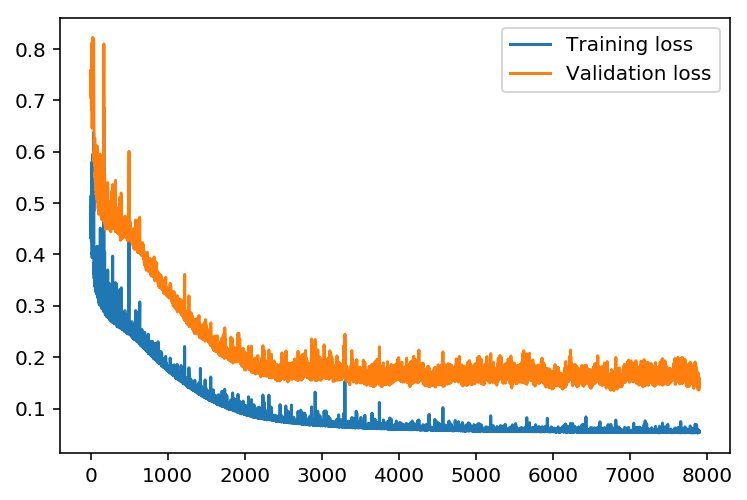

In [14]:
plt.plot(losses['train'][100:], label='Training loss')
plt.plot(losses['validation'][100:], label='Validation loss')
plt.legend()
_ = plt.ylim()

## 检查预测结果

使用测试数据看看网络对数据建模的效果如何。如果完全错了，请确保网络中的每步都正确实现。

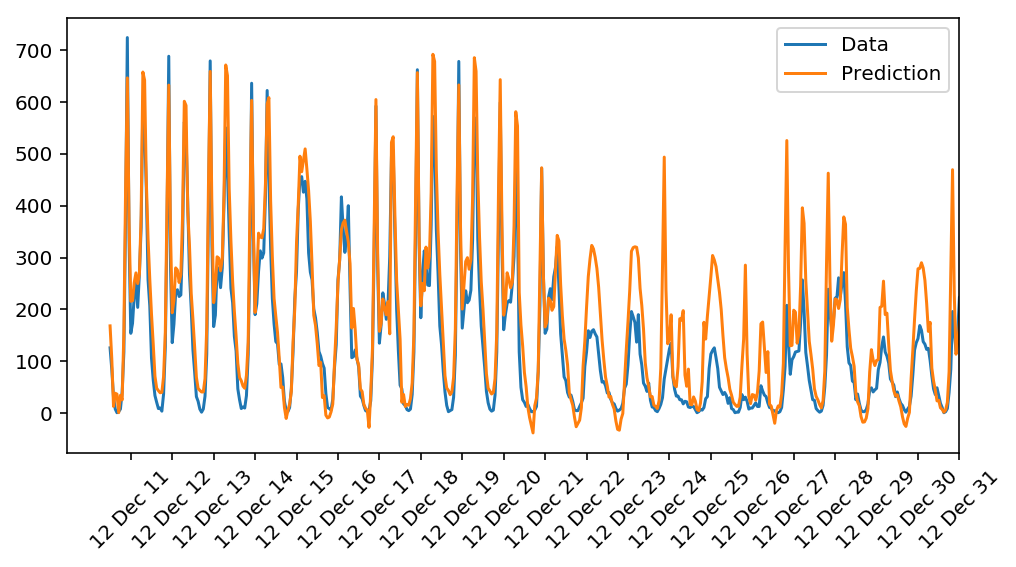

In [16]:
fig, ax = plt.subplots(figsize=(8,4))

mean, std = scaled_features['cnt']
predictions = network.predict(test_X) * std + mean
ax.plot(test_y * std + mean, label='Data')
ax.plot(predictions[0], label='Prediction')
ax.set_xlim(right=len(predictions))
ax.legend()

dates = pd.to_datetime(rides.ix[test_data.index]['dteday'])
dates = dates.apply(lambda d: d.strftime('%y %b %d'))
ax.set_xticks(np.arange(len(dates))[12::24])
_ = ax.set_xticklabels(dates[12::24], rotation=45)



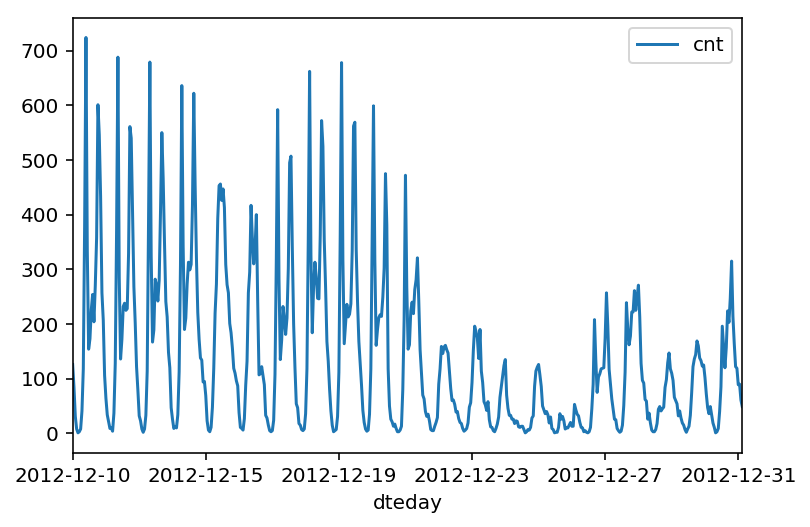

In [17]:
rides[-24*21:].plot(x='dteday', y='cnt')